<a href="https://colab.research.google.com/github/mdbshuvo/A-Basic-Neural-Network-with-NumPy/blob/main/code/NeuralNetwork_with_NumPy_CSE4112_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

# Reading the dataset

The dataset was imported from Google drive. The dataset is not publicly available.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset
data = pd.read_excel("/content/drive/MyDrive/CSE_4112/Grade Prediction Data (Responses).xlsx")
data.head()

,Daily Study Hour (0 - ),Average CT Marks (0 - 20),Class Attendance (percentage),PL/SPL Study Hours (Daily) (0 - ),PL/SPL Sleeping Hours (Daily Average),Average Sleeping Hours (Daily),Social Media Hours (Daily Average),PL/SPL Social Media Hours (Daily Average),Concentration in Classes (0 - 10),Confidence (0 - 10),Final Grade (last Semester - 3-2) (GPA)
0,1,8,65,12,6,8.0,3,1,NaN,3,3.25
1,2,12,95,9,10,10.0,2,1,7.0,7,3.84
2,2,15,96,13,6,8.0,5,2,5.0,8,3.61
3,1,9,70,6,8,8.0,3,2,7.0,9,3.41
4,1,8,60,10,9,8.0,2,2,3.0,4,3.14


# Preprocessing the dataset

The features and the labels are being separated. The null values are replaced with the feature mean.

In [ ]:
features = data.drop('Final Grade (last Semester - 3-2) (GPA) ', axis=1)
features.head()

,Daily Study Hour (0 - ),Average CT Marks (0 - 20),Class Attendance (percentage),PL/SPL Study Hours (Daily) (0 - ),PL/SPL Sleeping Hours (Daily Average),Average Sleeping Hours (Daily),Social Media Hours (Daily Average),PL/SPL Social Media Hours (Daily Average),Concentration in Classes (0 - 10),Confidence (0 - 10)
0,1,8,65,12,6,8.0,3,1,NaN,3
1,2,12,95,9,10,10.0,2,1,7.0,7
2,2,15,96,13,6,8.0,5,2,5.0,8
3,1,9,70,6,8,8.0,3,2,7.0,9
4,1,8,60,10,9,8.0,2,2,3.0,4


In [ ]:
# Null removal
for k in features.keys():
    features[k].mask(features[k].isnull(), other=np.mean(features[k]), inplace=True)

features.head()

,Daily Study Hour (0 - ),Average CT Marks (0 - 20),Class Attendance (percentage),PL/SPL Study Hours (Daily) (0 - ),PL/SPL Sleeping Hours (Daily Average),Average Sleeping Hours (Daily),Social Media Hours (Daily Average),PL/SPL Social Media Hours (Daily Average),Concentration in Classes (0 - 10),Confidence (0 - 10)
0,1,8,65,12,6,8.0,3,1,6.0,3
1,2,12,95,9,10,10.0,2,1,7.0,7
2,2,15,96,13,6,8.0,5,2,5.0,8
3,1,9,70,6,8,8.0,3,2,7.0,9
4,1,8,60,10,9,8.0,2,2,3.0,4


In [ ]:
target = data['Final Grade (last Semester - 3-2) (GPA) ']
target.head()

0    3.25
1    3.84
2    3.61
3    3.41
4    3.14
Name: Final Grade (last Semester - 3-2) (GPA) , dtype: float64

In [ ]:
target.min()

2.64

Discretizing the label.

In [ ]:
# Traget Discretizing
target.mask(3.75<=target, other=0, inplace=True)
target.mask((3.5<=target) & (target<3.75), other=1, inplace=True)
target.mask((3.25<=target) & (target<3.5), other=2, inplace=True)
target.mask((3.00<=target) & (target<3.25), other=3, inplace=True)
target.mask((2.75<=target) & (target<3.00), other=4, inplace=True)
target.mask((2.5<=target) & (target<2.75), other=5, inplace=True)

In [ ]:
target.head()

0    2.0
1    0.0
2    1.0
3    2.0
4    3.0
Name: Final Grade (last Semester - 3-2) (GPA) , dtype: float64

Computing the class weights.

In [ ]:
cls_count = []
for i in range(6):
    cls_count.append(target.where(target==i).count())

cls_count

[48, 11, 17, 7, 4, 1]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
# weights = 1 / np.array(cls_count)

weights = np.sum(cls_count) / (np.unique(target).shape[0] * np.array(cls_count))

weights_dict = {}

for i, j in enumerate(weights):
    weights_dict[i] = j

weights_dict

{0: 0.3055555555555556,
 1: 1.3333333333333333,
 2: 0.8627450980392157,
 3: 2.0952380952380953,
 4: 3.6666666666666665,
 5: 14.666666666666666}

One hot encoding the labels.

In [ ]:
# features and targets
X = np.array(features)
Y_raw = np.array(target, dtype='int')

# https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
# output one hot encoding
n_val = np.max(Y_raw) + 1
Y = np.eye(n_val)[Y_raw]

In [ ]:
Y_raw[:5]

array([2, 0, 1, 2, 3])

(array([48., 11., 17.,  7.,  4.,  1.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

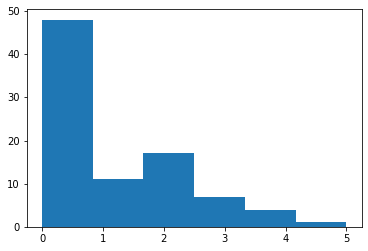

In [ ]:
plt.hist(Y_raw, 6)

In [ ]:
Y[:5]

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

Splitting the dataset into train test sets.

In [ ]:
# Splitting the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Building a layer

From: https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1

The derivative of softmax function is explained beautifully here. Had a lot of help from this link.

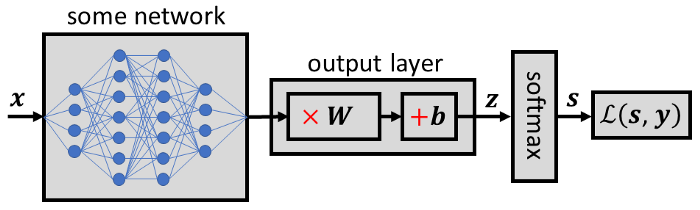

The derivative:   
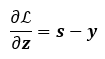

In [ ]:
# https://cs230.stanford.edu/files/C1M3.pdf

class NeuralNetwork:
    def __init__(self, nh_layers=1, nh_units=[4]):
        # hidden layers
        self.nh_layers = nh_layers
        self.nh_units = nh_units

        # input output layers
        self.inp_units = 10
        self.out_units = 6

        # weights and biases initialization
        self.W = [np.random.rand(self.nh_units[0], self.inp_units)]
        for i in range(1, self.nh_layers):
            self.W.append(np.random.rand(self.nh_units[i], self.nh_units[i-1]))
        self.W.append(np.random.rand(self.out_units, self.nh_units[self.nh_layers-1]))

        self.b = []
        for i in range(self.nh_layers):
            self.b.append(np.zeros((self.nh_units[i], 1)))
        self.b.append(np.zeros((self.out_units, 1)))
    
    def show_params(self):
        print("Weights : ")
        for i, j in enumerate(self.W):
            print(i+1, ' layer:') if i!=len(self.W)-1 else print('output layer:')
            print(j)

        print("Biases : ")
        for i, j in enumerate(self.b):
            print(i+1, ' layer:') if i!=len(self.b)-1 else print('output layer:')
            print(j)

    def fit(self, X, y, lr=1e-5, epoch=20, weights=None):
        N = X.shape[0]
        if weights is not None:
            weights = np.array([weights])

        if N != y.shape[0]:
            raise("Features and labels number of samples doesn't match")

        for i in range(epoch):
            layer_outputs, zs = self.pred(X, fit_called=True)
            y_pred = layer_outputs[-1].T

            # categorical cross entropy
            if weights is None:
                cce = -np.sum(y*np.log(y_pred)) / N
            else:
                cce = -np.sum(y*np.log(y_pred)*weights) / N

            print(i+1, cce)

            # back propagation

            # output layer
            if weights is None:
                dz_out = (y_pred - y).T
            else:
                dz_out = ((y_pred - y)*weights).T
            dw = [np.matmul(dz_out, layer_outputs[-2].T)]
            db = [np.mean(dz_out, axis=1, keepdims=True)]
            # print(len(layer_outputs), layer_outputs[-4].shape)
            # print(dw[0].shape, db[0].shape)
            # print(dw, db)

            # intermediate layers
            dz = dz_out.copy()
            ind = 1
            for i in range(self.nh_layers-1, 0, -1):
                dz = np.matmul(self.W[i+1].T, dz) * ((zs[i] > 0) * 1) # The later part is derivative of Relu 
                dw.insert(0, np.matmul(dz, layer_outputs[-2-ind].T))
                db.insert(0, np.mean(dz, axis=1, keepdims=True))
                # print(dz.shape, layer_outputs[-2-ind].shape, -2-ind, dw[0].shape, db[0].shape)
                # print(dw, db)

                ind += 1

            # First layer
            dz = np.matmul(self.W[1].T, dz) * ((zs[0] > 0) * 1) # The later part is derivative of Relu 
            dw.insert(0, np.matmul(dz, X))
            db.insert(0, np.mean(dz, axis=1, keepdims=True))
            # print(dw[0].shape, db[0].shape)
            # print(dw, db)

            for i in range(len(self.W)):
                self.W[i] = self.W[i] - lr*dw[i]
                self.b[i] = self.b[i] - lr*db[i]

            # print(dw)
            # print(db)
    
    def pred(self, X, fit_called=False):
        y_pred = np.array(X).T

        layer_outs = []
        zs = []
        for i in range(self.nh_layers+1): # extra 1 is for output layer
            y_pred = np.matmul(self.W[i], y_pred) + self.b[i]
            zs.append(y_pred)

            # relu
            if i!= self.nh_layers:
                y_pred = np.maximum(y_pred, 0)
                layer_outs.append(y_pred)

        # softmax
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=0, keepdims=True)
        layer_outs.append(y_pred)

        if not fit_called:
            return y_pred.T
        else:
            return layer_outs, zs

In [ ]:
nn = NeuralNetwork(2, [3,4])
nn.show_params()

Weights : 
1  layer:
[[0.36565378 0.02913339 0.16303088 0.43101469 0.41156409 0.05313858
  0.3993803  0.6764647  0.03946558 0.08003232]
 [0.64439164 0.55670773 0.83372978 0.68866128 0.70864162 0.31554734
  0.55490263 0.28705441 0.22652063 0.85802463]
 [0.98091921 0.80359659 0.26547163 0.07760041 0.53507329 0.21400199
  0.53682866 0.55707976 0.53321183 0.73506645]]
2  layer:
[[0.77095318 0.10300388 0.93742605]
 [0.11106743 0.0669874  0.15237592]
 [0.70724005 0.3939264  0.64868199]
 [0.66489463 0.7692136  0.57834213]]
3  layer:
[[0.14782209 0.05262521 0.96191877 0.65103914]
 [0.24659558 0.95373123 0.92234076 0.71461509]
 [0.73832977 0.03841482 0.16085318 0.33699102]
 [0.93930763 0.36165667 0.09119717 0.96403047]]
output layer:
[[0.84868456 0.21079593 0.85306201 0.18263254]
 [0.00607931 0.03062973 0.46130638 0.01029638]
 [0.07083901 0.59971078 0.82024949 0.62622441]
 [0.61423535 0.07667504 0.87394323 0.96642155]
 [0.56966727 0.49389379 0.49088028 0.547607  ]
 [0.16288027 0.90192647 0.9017

In [ ]:
nn.fit(X_train, y_train, lr=1e-6, epoch=100, weights=weights)

y_pred_test = nn.pred(X_test)

1 121.71032529195992
2 94.87744500663825
3 72.57115111609679
4 64.57823481218377
5 49.14278838691768
6 44.715602230516225
7 41.45515839043961
8 38.52663327830459
9 35.299982168658346
10 32.96158609296242
11 30.787251996371964
12 30.082206240113457
13 29.68824373425459
14 29.37979887988545
15 29.101393315982975
16 28.83721349389126
17 28.58123071462558
18 28.33074535979175
19 28.084412202496903
20 27.841508262303524
21 27.601621986389798
22 27.364507057335857
23 27.130008316942238
24 26.89802441350343
25 26.67234486215654
26 26.44909527752892
27 26.228195249117054
28 26.009586986007843
29 25.79322482597826
30 25.579070184487485
31 25.36708883498117
32 25.15724934255
33 24.949522129623016
34 24.74387890882889
35 24.540292335313
36 24.338735791868285
37 24.1391832548625
38 23.941609209438308
39 23.745988594819817
40 23.55227396816649
41 23.35310483182712
42 23.15979965579879
43 22.968394680107203
44 22.782690952006586
45 22.601344846994188
46 22.42175025265807
47 22.24387139065946
48 22.0

In [ ]:
nn.show_params()

Weights : 
1  layer:
[[ 0.36150867 -0.02475488 -0.09425154  0.40685096  0.40189405  0.03736245
   0.39970723  0.68515708  0.01898697  0.05540437]
 [ 0.64141024  0.52579062  0.67082408  0.67367742  0.70077289  0.30467878
   0.55369705  0.29007178  0.21446401  0.84410257]
 [ 0.97527633  0.74181908 -0.04354789  0.04903444  0.52148105  0.194106
   0.53624123  0.56493183  0.50951439  0.70778902]]
2  layer:
[[ 0.75636056 -0.0546796   0.87142626]
 [ 0.10954996 -0.01664058  0.12376931]
 [ 0.70327226  0.27006121  0.60589558]
 [ 0.64973715  0.58286839  0.5038189 ]]
3  layer:
[[0.1158275  0.04550784 0.91453827 0.58202424]
 [0.2411077  0.95210323 0.90430458 0.68316556]
 [0.7107212  0.03169433 0.11919847 0.27493213]
 [0.88463286 0.34963284 0.01822922 0.86207369]]
output layer:
[[ 0.85014498  0.2131324   0.85592662  0.18636865]
 [ 0.12781069  0.17093182  0.52148455  0.1307939 ]
 [ 0.04898906  0.5736654   0.80817779  0.60353837]
 [ 0.50604283 -0.0497579   0.80959598  0.84726337]
 [ 0.49979042  0.4117

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_test = n.pred(X_test)
y_pred = (y_pred_test == np.max(y_pred_test, axis=1, keepdims=True)) * 1

print("Accuracy:", accuracy_score(y_test, y_pred))
#confusion matrix
cm=np.array(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
cm

Accuracy: 0.4444444444444444


array([[8, 0, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [4, 0, 0, 0, 0],
       [2, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

# Exercize

In [ ]:
y_pred = [1,3,2]
np.exp(y_pred) / np.sum(np.exp(y_pred))

array([0.09003057, 0.66524096, 0.24472847])

In [ ]:
(y_pred_test == np.max(y_pred_test, axis=1, keepdims=True)) * 1